<a href="https://colab.research.google.com/github/nitin-barthwal/Machine-Learning-Projects/blob/master/Credit_card_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit card fraud detection**

I recently found this publicly available dataset of credit card transactions on Kaggle so I thought it might be interesting to play with it a bit and see how good classification results can I get. In this article I’d like to share with you how to overcome imbalance in target classes, how to choose right metrics for the model as well as results I came up with.



# In this Tutorial you will see the implimentation of -

## 1) Stratified sampling

## 2) SMOTe

## 3) Random Forest with Bagging

## 4) Evaluation Metric ( F1 Sore and Cohen Kappa Sore )

In [0]:
from google.colab import files

uploaded = files.upload()


In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import f1_score, recall_score


**The data**

We build our models on a dataset obtained at "https://www.kaggle.com/dalpozz/creditcardfraud/data", which includes credit transactions made in Europe during a 48-hour period in September 2013. In below cell, we load the data and take a quick peek.



In [0]:
# Read the CSV file
df = pd.read_csv('creditcard.csv')

# Show the contents
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven’t been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [0]:
print(df.describe())


               Time            V1            V2            V3            V4  \
count  69918.000000  69918.000000  69918.000000  69918.000000  69918.000000   
mean   34655.925127     -0.245175     -0.020551      0.681731      0.169405   
std    14408.233994      1.866564      1.654595      1.420028      1.375114   
min        0.000000    -56.407510    -72.715728    -33.680984     -5.172595   
25%    28753.500000     -1.006076     -0.592455      0.195185     -0.724106   
50%    37896.000000     -0.243873      0.071856      0.770982      0.188127   
75%    45453.000000      1.153607      0.727702      1.403575      1.052412   
max    53635.000000      1.960497     18.902453      4.226108     16.715537   

                 V5            V6            V7            V8            V9  \
count  69918.000000  69918.000000  69918.000000  69918.000000  69918.000000   
mean      -0.271509      0.101237     -0.115377      0.058017      0.020451   
std        1.393335      1.307095      1.259604    

Let’s check for missing values:

In [0]:
df.isnull().values.any()


True

We got some missing values . Lets find out which column have null values. Later we will see the rows with missing values.

In [0]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64

V21 to class column have 1 missing row. Lets see -

Displaying the rows witch has null value

In [0]:
print(df[df.isnull().any(axis=1)])

        Time        V1        V2        V3        V4        V5       V6  \
69917  53635  1.129673 -0.294148  0.901983  0.862134 -0.475717  1.12692   

             V7        V8        V9  ...    V21  V22  V23  V24  V25  V26  V27  \
69917 -1.050507  0.563206  0.745961  ...    NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       V28  Amount  Class  
69917  NaN     NaN    NaN  

[1 rows x 31 columns]


As there is onlly one row in the dataset which has missing values hence removing it .

In [0]:

df = df.dropna()     #drop all rows that have any NaN values
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [0]:
def normalize(X):
    """
    Make the distribution of the values of each variable similar by subtracting the mean and by dividing by the standard deviation.
    """
    for feature in X.columns:
        X[feature] -= X[feature].mean()
        X[feature] /= X[feature].std()
    return X

Now we have dealt with the missing values , we are good to go.

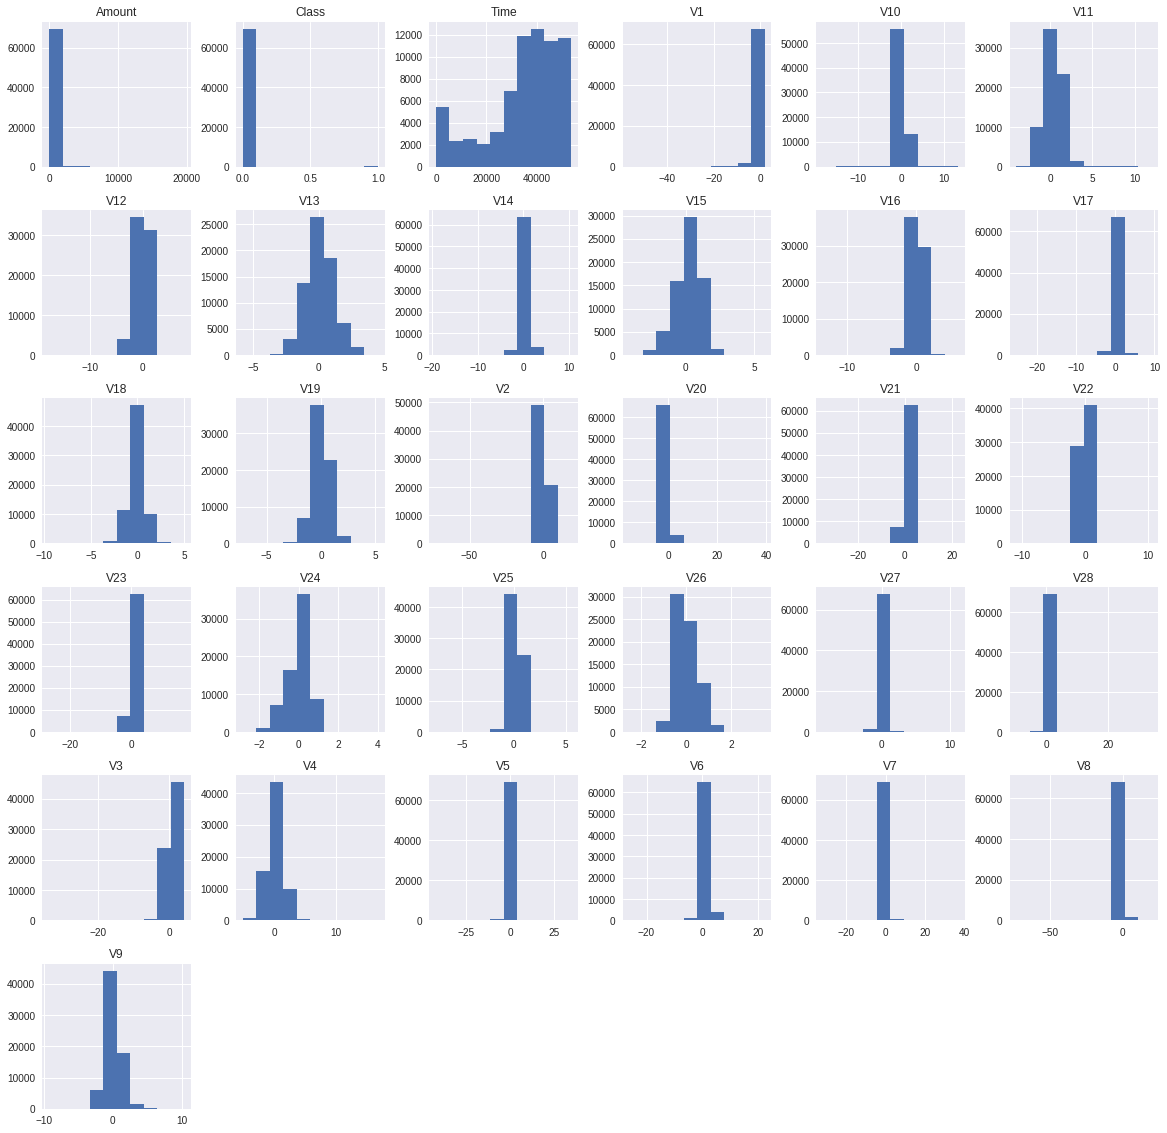

In [0]:
df.hist(figsize=(20,20))
plt.show()


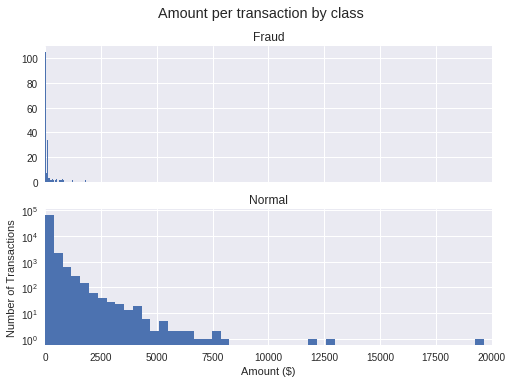

In [0]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Visualising the Class labels 

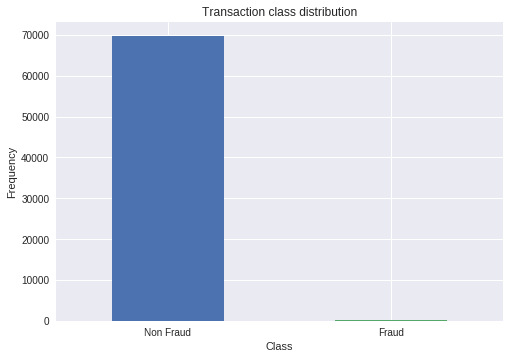

In [0]:
LABELS = ['Non Fraud' , 'Fraud']
import matplotlib.pyplot as plt
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar',rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");



We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let’s see how many Fraud and non fraud cases we have  in the dataset :





In [0]:
print ('No. of genuine transactions: %d \nNo. of fraudulent transactions: %d' %(np.sum(df['Class'] == 0), np.sum(df['Class'] == 1) )  )

No. of genuine transactions: 69743 
No. of fraudulent transactions: 174


The dataset contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.



Do fraudulent transactions occur more often during certain time?



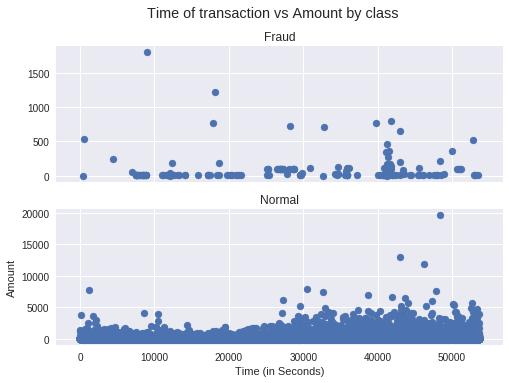

In [0]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]


f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()


The first column is time. We believe it is only an indicator and does not affect the classification. 
X => Data 
Y => Target

In [0]:
X = df.iloc[:, 1:30]
Y = df.iloc[:, -1]


In [0]:
print("Fraud transaction statistics")
print(frauds["Amount"].describe())
print("\nNormal transaction statistics")
print(normal["Amount"].describe())

print("Fraud Cases ", frauds.shape)
print(" Normal Cases " , normal.shape)

Fraud transaction statistics
count     174.000000
mean       95.218218
std       220.573811
min         0.000000
25%         1.000000
50%         7.595000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

Normal transaction statistics
count    69743.000000
mean        96.994847
std        271.312912
min          0.000000
25%          7.680000
50%         26.520000
75%         88.525000
max      19656.530000
Name: Amount, dtype: float64
Fraud Cases  (174, 31)
 Normal Cases  (69743, 31)


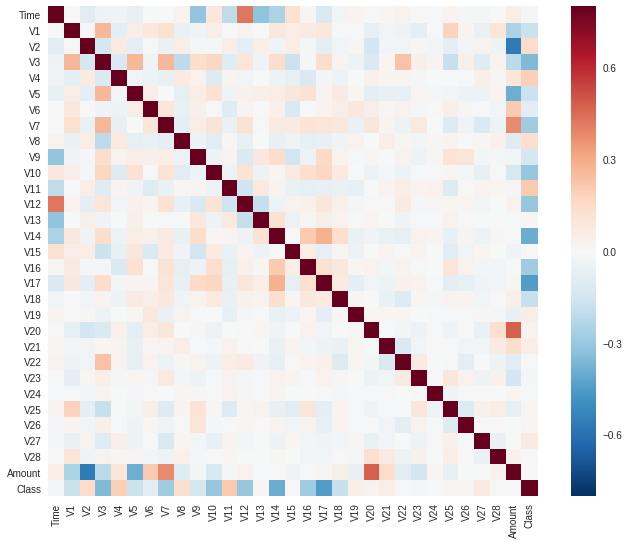

In [0]:
correlation_matrix = df.corr()

fig = plt.figure(figsize=(12,9))

sns.heatmap(correlation_matrix,vmax=0.8,square = True)

plt.show()

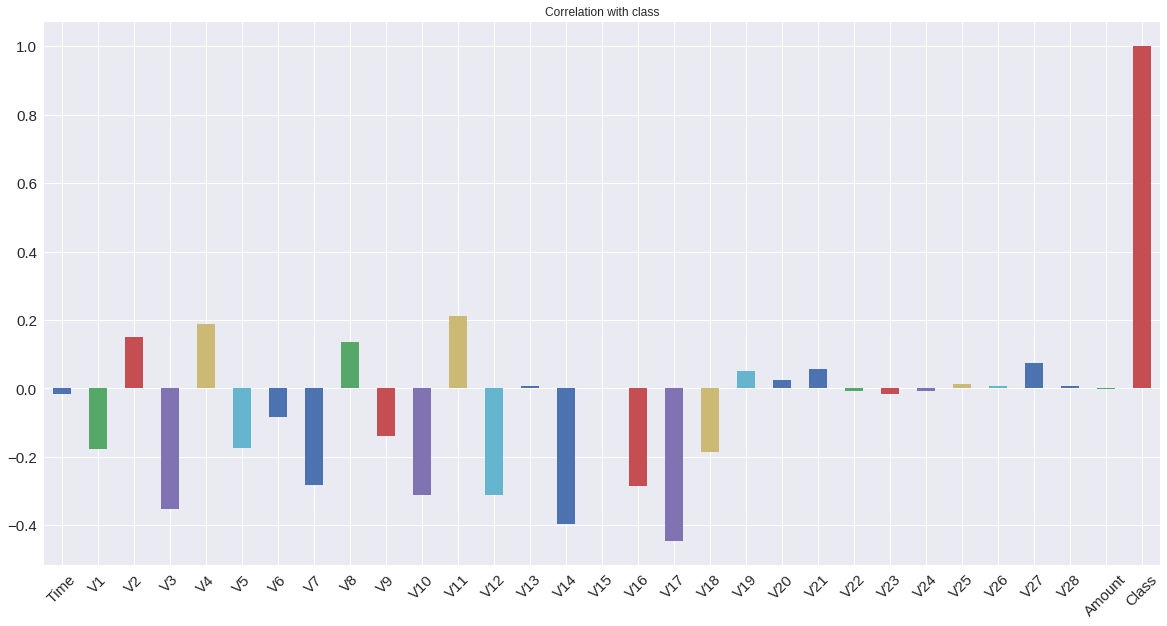

In [0]:
df.corrwith(data.Class).plot.bar(
        figsize = (20, 10), title = "Correlation with class", fontsize = 15,
        rot = 45, grid = True)


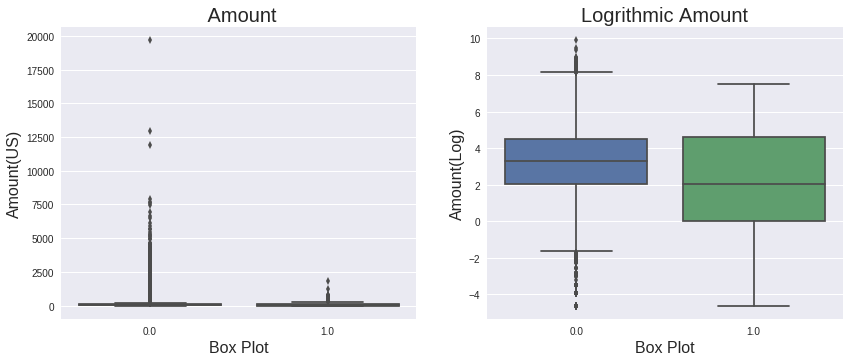

In [0]:
#Feature engineering to a better visualization of the values
data_new=df.copy()
data_new['Amount_log'] = np.log(data_new.Amount + 0.01) #logaritmic transformation due to skewness of fraud transaction distributon
plt.figure(figsize=(14,6))
#distribution of amount by time variable:
plt.subplot(121)
ax = sns.boxplot(x ="Class",y="Amount",
                 data=data_new)
ax.set_title(" Amount", fontsize=20)
ax.set_xlabel("Box Plot", fontsize=16)
ax.set_ylabel("Amount(US)", fontsize = 16)

plt.subplot(122)

ax1 = sns.boxplot(x ="Class",y="Amount_log", data=data_new)
ax1.set_title("Logrithmic Amount", fontsize=20)
ax1.set_xlabel("Box Plot", fontsize=16)
ax1.set_ylabel("Amount(Log)", fontsize = 16)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()


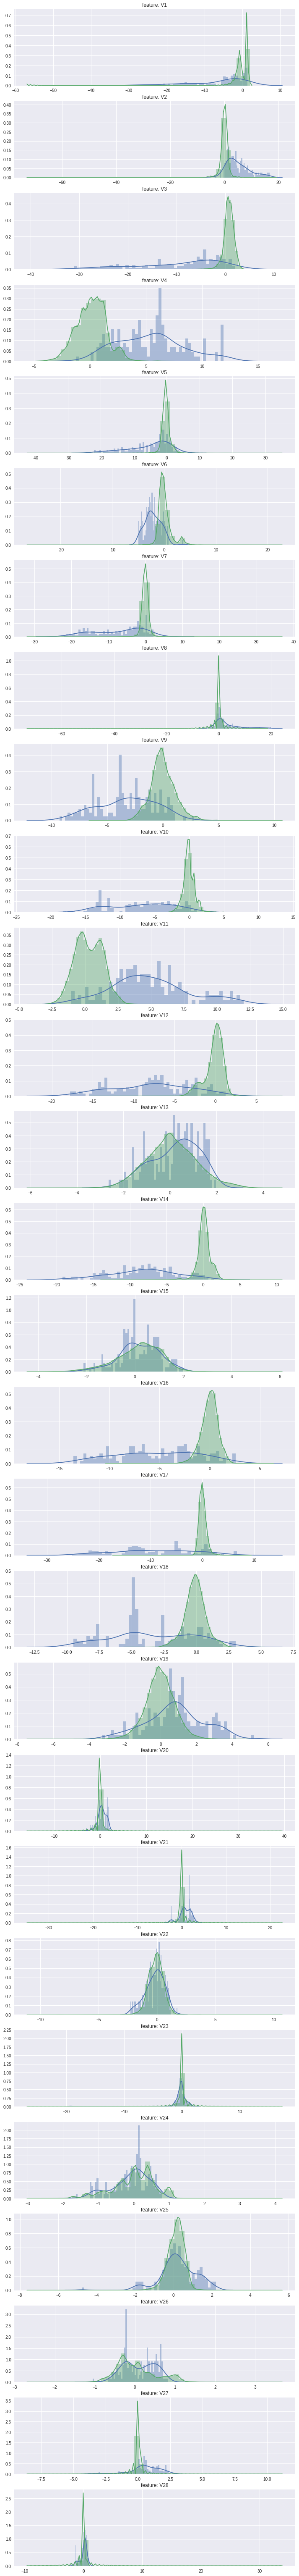

In [0]:
### distribution of each classes for syntethic variables between V1-V28

plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(data_new[df.iloc[:, 1:29].columns]):
   ax = plt.subplot(gs[i])
   sns.distplot(data_new[cn][df.Class == 1], bins=50)
   sns.distplot(data_new[cn][df.Class == 0], bins=50)
   ax.set_xlabel('')
   ax.set_title('feature: ' + str(cn))
plt.show()


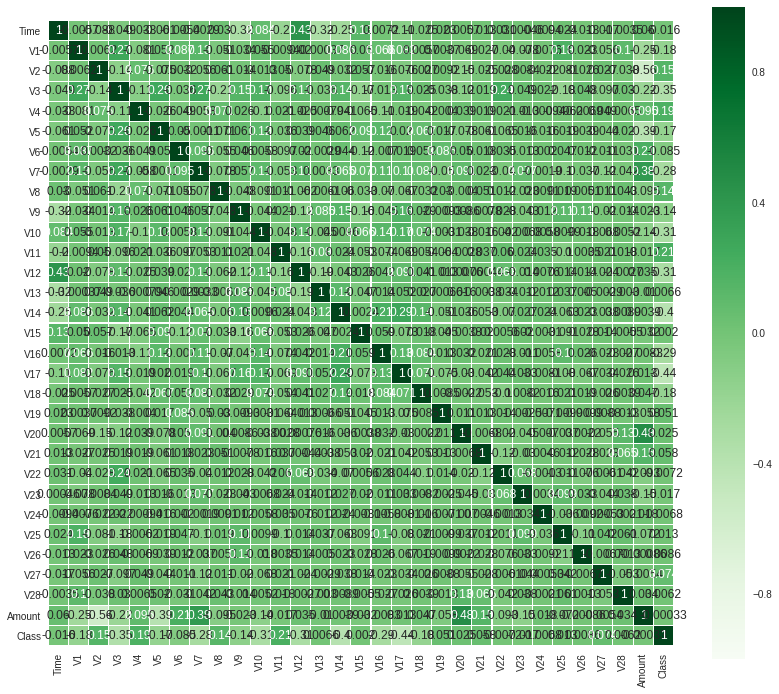

In [0]:
##Corelation matrix for whole data
colormap = plt.cm.Greens
plt.figure(figsize=(14,12))

sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap = colormap, linecolor='white', annot=True)
plt.show()



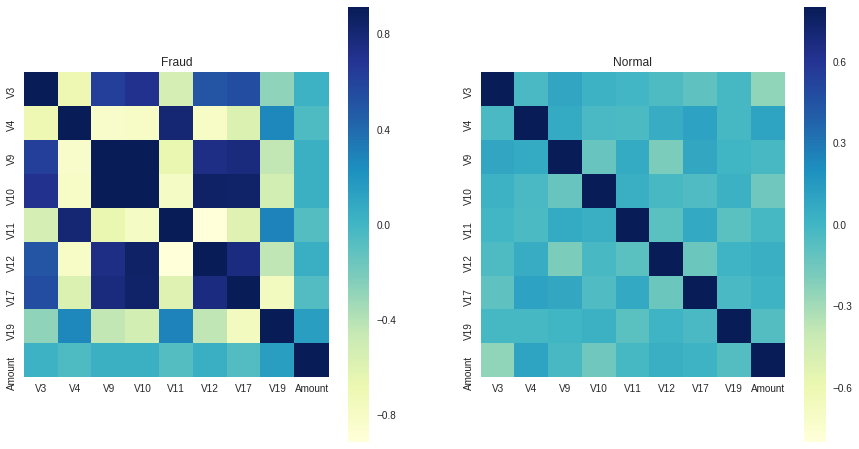

In [0]:
#Feauture selection

data_new2 = df[["V3","V4","V9","V10","V11","V12","V17","V19","Amount","Class"]]

#correlation matrix
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 15, 8))

sns.heatmap(data_new2.query('Class==1').drop(['Class'],1).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(data_new2.query('Class==0').drop(['Class'],1).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

We then partition the data into three datasets, i.e., train, validation, and test datasets.

Before we start training the model we’ll need to split our dataset into a training and test portion. We’ll use the training portion to train model and then evaluate it on the test portion to see how it performs on samples it hasn’t seen before. It’s also important to perform a stratified sampling which means that the probability of seeing a fraudulent transaction will be approximately the same in both the training data and the test data. Stratified sampling also ensures that our model metrics are as close as possible to what we’d see in a whole population.





In [0]:
from sklearn.model_selection import train_test_split
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X,    Y,  test_size=0.20, random_state=1,stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_train,    y_train,  test_size=0.20, random_state=1,stratify=y_train)

print(X_train.size)
print(y_train.size)

1297634
44746


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns #to visualization
import matplotlib.pyplot as plt # to plot the graphs
import matplotlib.gridspec as gridspec # to do the grid of plots
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score ,auc, roc_curve
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, neural_network
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore') #ignore warning messages 


In [0]:
def PrintStats(cmat, y_test, pred):
   # separate out the confusion matrix components
   tpos = cmat[0][0]
   fneg = cmat[1][1]
   fpos = cmat[0][1]
   tneg = cmat[1][0]
   # calculate F!, Recall scores
   f1Score = round(f1_score(y_test, pred), 2)
   recallScore = round(recall_score(y_test, pred), 2)
   # calculate and display metrics
   print(cmat)
   print( 'Accuracy: '+ str(np.round(100*float(tpos+fneg)/float(tpos+fneg + fpos + tneg),2))+'%')
   print( 'Cohen Kappa: '+ str(np.round(cohen_kappa_score(y_test, pred),3)))
   print("Sensitivity/Recall for Model : {recall_score}".format(recall_score = recallScore))
   print("F1 Score for Model : {f1_score}".format(f1_score = f1Score))

In [0]:
def RunModel(model, X_train, y_train, X_test, y_test):
   model.fit(X_train, y_train.values.ravel())
   pred = model.predict(X_test)
   matrix = confusion_matrix(y_test, pred)
   return matrix, pred

In [0]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
cmat, pred = RunModel(lr, X_train, y_train, X_test, y_test)
PrintStats(cmat, y_test, pred)

[[13943     6]
 [   14    21]]
Accuracy: 99.86%
Cohen Kappa: 0.677
Sensitivity/Recall for Model : 0.6
F1 Score for Model : 0.68


# **Applied SMOTe Technique on Linear regression**

In [0]:
print("Old size X" , X_train.size)

print("old Size y", y_train.size)

smt = SMOTE()
sm_X_train, sm_y_train = smt.fit_sample(X_train, y_train)
print("New size X",sm_X_train.size)
print("New Size y", sm_y_train.size)


Old size X 1297634
old Size y 44746
New size X 2588830
New Size y 89270


In [0]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
model.fit(sm_X_train, sm_y_train)
pred = model.predict(X_test)
matrix = confusion_matrix(y_test, pred)

PrintStats(matrix, y_test, pred)

[[13689   260]
 [    2    33]]
Accuracy: 98.13%
Cohen Kappa: 0.198
Sensitivity/Recall for Model : 0.94
F1 Score for Model : 0.2


In [0]:
from sklearn import ensemble
lr = ensemble.AdaBoostClassifier()
cmat, pred = RunModel(lr, X_train, y_train, X_test, y_test)
PrintStats(cmat, y_test, pred)


[[13946     3]
 [    8    27]]
Accuracy: 99.92%
Cohen Kappa: 0.83
Sensitivity/Recall for Model : 0.77
F1 Score for Model : 0.83


In [0]:
lr = ensemble.GradientBoostingClassifier()
cmat, pred = RunModel(lr, X_train, y_train, X_test, y_test)
PrintStats(cmat, y_test, pred)


[[13940     9]
 [    4    31]]
Accuracy: 99.91%
Cohen Kappa: 0.826
Sensitivity/Recall for Model : 0.89
F1 Score for Model : 0.83


In [0]:
#from sklearn.ensemble import RandomForestClassifier
#Naive_bayes_model=naive_bayes.GaussianNB()
from sklearn.naive_bayes import GaussianNB 

rf = GaussianNB()
cmat, pred = RunModel(rf, X_train, y_train, X_test, y_test)
PrintStats(cmat, y_test, pred)

[[13684   265]
 [    4    31]]
Accuracy: 98.08%
Cohen Kappa: 0.184
Sensitivity/Recall for Model : 0.89
F1 Score for Model : 0.19


We are going to re-balance our data using the Synthetic Minority Over-sampling Technique (SMOTE). Unlike ROS, SMOTE does not create exact copies of observations, but creates new, synthetic, samples that are quite similar to the existing observations in the minority class. 

SMOTE is therefore slightly more sophisticated than just copying observations.

'auto': equivalent to 'not majority'.




In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, n_jobs =4)
cmat, pred = RunModel(rf, X_train, y_train, X_test, y_test)
PrintStats(cmat, y_test, pred)

[[13948     1]
 [    4    31]]
Accuracy: 99.96%
Cohen Kappa: 0.925
Sensitivity/Recall for Model : 0.89
F1 Score for Model : 0.93


In [0]:
####confusion_Matrix

# confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


####recall-F1 Score-Precision

def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

# precision-recall curve
def plot_precision_recall():
    plt.step(recall_score, precision_score, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall_score, precision_score, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall_score, precision_score, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

# ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();
#feature importance plot
def plot_feature_importance(model):
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (12,12))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

In [0]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import itertools
from sklearn import metrics
from sklearn.metrics import roc_auc_score


The number of transactions after resampling : 139486
If the number of frauds is equal to the number of normal tansactions? True


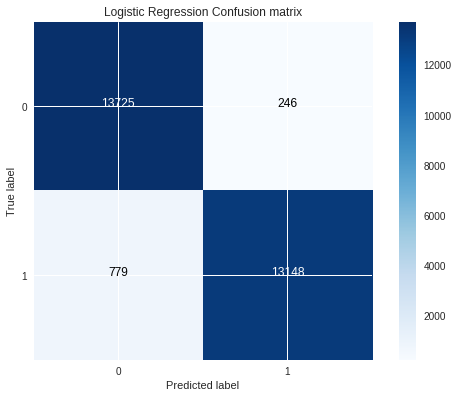

Precision =     0.982
Recall    =     0.944
F1_score  =     0.962
ROC AUC Score: 0.9632287911140822


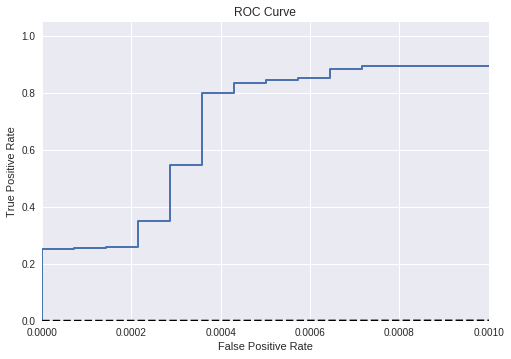

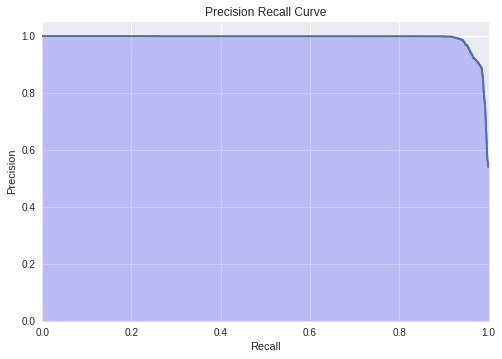

In [0]:
#####Logistic Regression

#####LogisticRegression with Three Sampling Method 
#SMOTE
X = df.drop('Class', axis=1)
y = df.Class
X_resample, y_resample = SMOTE().fit_sample(X, y)  ## Random Oversampler(), SMOTE; Random Undersampler
print ( 'The number of transactions after resampling : ' + str(len(X_resample)))
print ('If the number of frauds is equal to the number of normal tansactions? ' + str(sum(y_resample == 0) == sum(y_resample == 1))
       )
##training size 0.8
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=3)
X = df.drop('Class', axis=1)
y = df.Class
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
y_pred = logistic_reg.predict(X_test)
y_score = logistic_reg.decision_function(X_test)

# Confusion matrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm,
                      classes = class_names,
                      title = 'Logistic Regression Confusion matrix')
plt.show()
show_metrics()
## ROC_AUC Curve Score
print('ROC AUC Score:',metrics.roc_auc_score(y_test, y_pred))
# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()
# Precision-recall curve
precision_score, recall_score, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()
